In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [89]:
airports = pd.read_csv("data/Airports Data.csv")
bag_level = pd.read_csv("data/Bag+Level+Data.csv")
flight_level = pd.read_csv("data/Flight Level Data.csv")
pnr_remark_level = pd.read_csv("data/PNR Remark Level Data.csv")
pnr_flight_level = pd.read_csv("data/PNR+Flight+Level+Data.csv")


In [90]:
# Drop flights with invalid ground times
invalid = (flight_level['scheduled_ground_time_minutes'] <= 0).sum()
print(f"Dropping {invalid} flights with negative ground times")

flight_level = flight_level[flight_level['scheduled_ground_time_minutes'] >= 0].copy()

Dropping 312 flights with negative ground times


In [91]:
# Convert datetime columns
flight_level['scheduled_departure_datetime_local'] = pd.to_datetime(
    flight_level['scheduled_departure_datetime_local']
)
flight_level['actual_departure_datetime_local'] = pd.to_datetime(
    flight_level['actual_departure_datetime_local']
)
flight_level['scheduled_arrival_datetime_local'] = pd.to_datetime(
    flight_level['scheduled_arrival_datetime_local']
)
flight_level['scheduled_departure_date_local'] = pd.to_datetime(
    flight_level['scheduled_departure_date_local']
)


In [92]:
# Remove duplicates based on scheduled_departure and flight_number
before_flight = len(flight_level)
flight_level = flight_level.drop_duplicates(subset=['scheduled_departure_datetime_local', 'flight_number'], keep='first')
print(f"Removed {before_flight - len(flight_level)} duplicate rows based on scheduled_departure_datetime_local + flight_number")

# Remove fleet_type column
if 'fleet_type' in flight_level.columns:
    flight_level = flight_level.drop(columns=['fleet_type'])
    print("Removed 'fleet_type' column")
    
# Remove true duplicates 
before_true_dup = len(flight_level)
flight_level = flight_level.drop_duplicates()

Removed 16 duplicate rows based on scheduled_departure_datetime_local + flight_number
Removed 'fleet_type' column


In [93]:
# Calculate delay in minutes
flight_level['delay_minutes'] = (
    flight_level['actual_departure_datetime_local'] - 
    flight_level['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

EDA Question 1: Delay Analysis

In [132]:
# Calculate delay in minutes
flight_level['delay_minutes'] = (
    flight_level['actual_departure_datetime_local'] - 
    flight_level['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

# Separate metrics for clarity
avg_delay_all = flight_level['delay_minutes'].mean()
avg_delay_delayed_only = flight_level[flight_level['delay_minutes'] > 0]['delay_minutes'].mean()

delayed_flights = (flight_level['delay_minutes'] > 0).sum()
early_flights = (flight_level['delay_minutes'] < 0).sum()
ontime_flights = (flight_level['delay_minutes'] == 0).sum()

pct_delayed = (delayed_flights / len(flight_level)) * 100
pct_early = (early_flights / len(flight_level)) * 100

print(f"Overall average (including early): {avg_delay_all:.2f} minutes")
print(f"Average delay (delayed flights only): {avg_delay_delayed_only:.2f} minutes")
print(f"")
print(f"Delayed flights: {delayed_flights:,} ({pct_delayed:.2f}%)")
print(f"Early flights: {early_flights:,} ({pct_early:.2f}%)")
print(f"On-time flights: {ontime_flights:,}")

Overall average (including early): 17.18 minutes
Average delay (delayed flights only): 40.70 minutes

Delayed flights: 3,712 (47.72%)
Early flights: 3,724 (47.88%)
On-time flights: 342


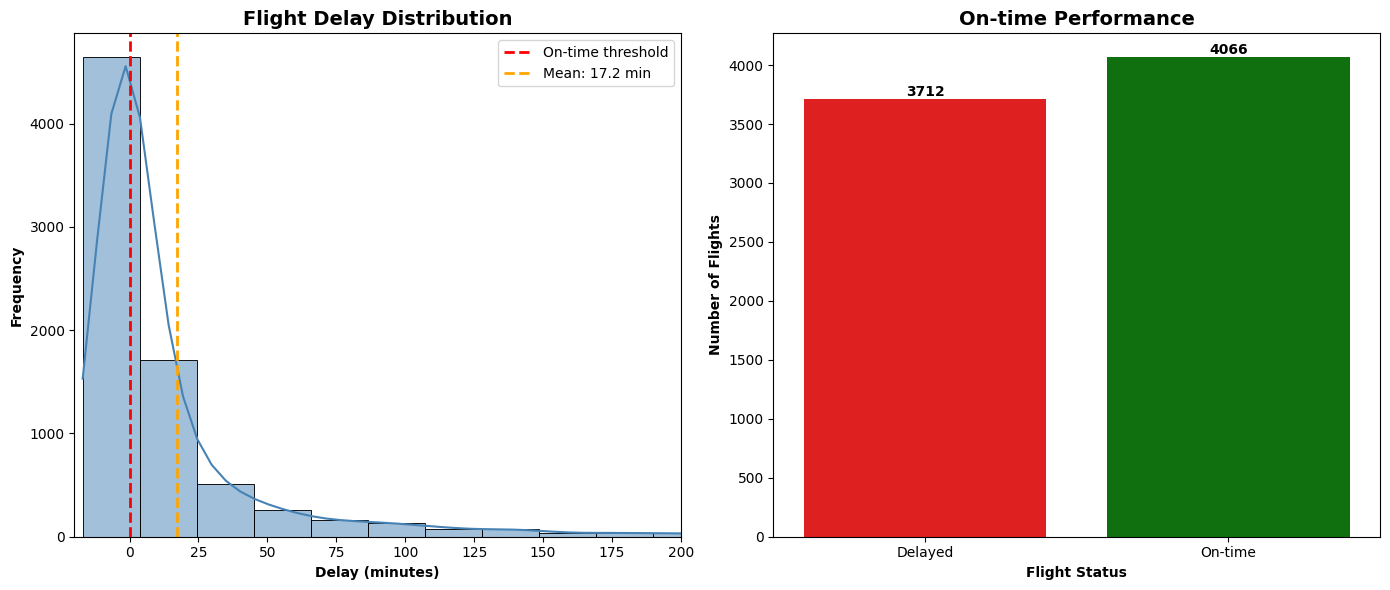

In [96]:
# Visualization: Delay Distribution (clean + warning-free)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Distribution plot with KDE
sns.histplot(
    data=flight_level, 
    x='delay_minutes', 
    bins=50, 
    kde=True, 
    color='steelblue', 
    ax=axes[0]
)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='On-time threshold')
axes[0].axvline(x=avg_delay, color='orange', linestyle='--', linewidth=2, 
                label=f'Mean: {avg_delay:.1f} min')

# Limit x-axis for better visibility
axes[0].set_xlim(-20, 200)
axes[0].set_xlabel('Delay (minutes)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Flight Delay Distribution', fontsize=14, fontweight='bold')
axes[0].legend()

# 2. Count plot for on-time vs delayed (no warning)
sns.countplot(
    data=flight_level, 
    x='status', 
    hue='status', 
    palette={'On-time': 'green', 'Delayed': 'red'}, 
    legend=False, 
    ax=axes[1]
)

axes[1].set_xlabel('Flight Status', fontweight='bold')
axes[1].set_ylabel('Number of Flights', fontweight='bold')
axes[1].set_title('On-time Performance', fontsize=14, fontweight='bold')

# Add counts on bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()


EDA Question 2: Ground Time Analysis

Average ground time ratio: 4.18x minimum
Flights with tight turnaround (≤1.1x min): 471 (6.06%)


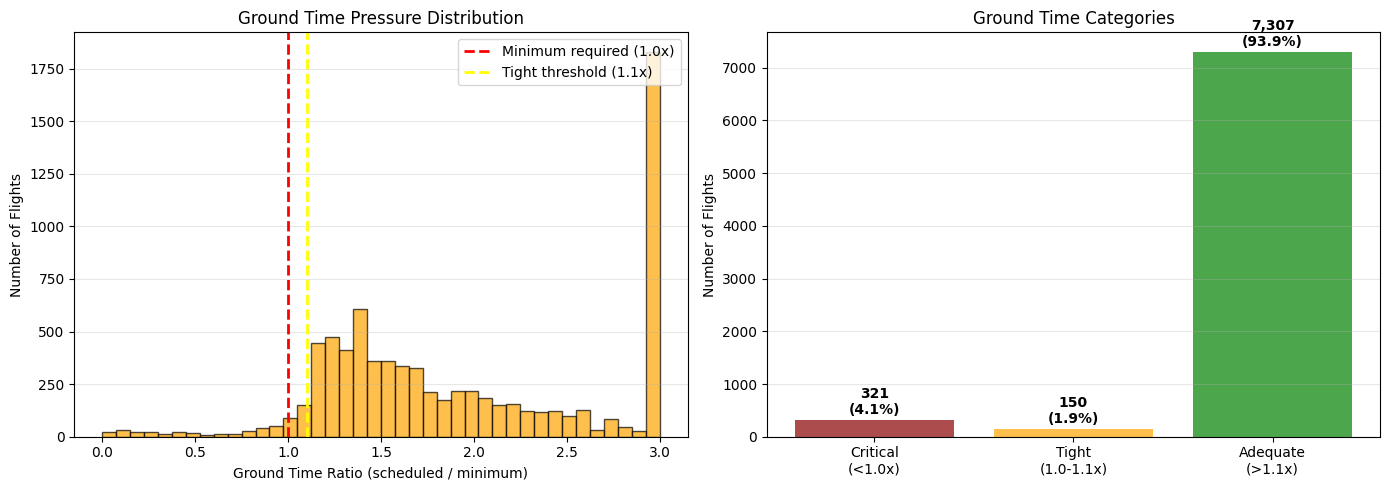

In [98]:
# Calculate ground time ratio
flight_level['ground_time_ratio'] = (
    flight_level['scheduled_ground_time_minutes'] / 
    flight_level['minimum_turn_minutes']
)

tight_turnaround = (flight_level['ground_time_ratio'] <= 1.1).sum()
pct_tight = (tight_turnaround / len(flight_level)) * 100

print(f"Average ground time ratio: {flight_level['ground_time_ratio'].mean():.2f}x minimum")
print(f"Flights with tight turnaround (≤1.1x min): {tight_turnaround:,} ({pct_tight:.2f}%)")

# Visualization: Ground Time Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground time ratio distribution
axes[0].hist(flight_level['ground_time_ratio'].clip(upper=3), bins=40, 
            edgecolor='black', alpha=0.7, color='orange')
axes[0].axvline(x=1.0, color='red', linestyle='--', linewidth=2, 
               label='Minimum required (1.0x)')
axes[0].axvline(x=1.1, color='yellow', linestyle='--', linewidth=2, 
               label='Tight threshold (1.1x)')
axes[0].set_xlabel('Ground Time Ratio (scheduled / minimum)')
axes[0].set_ylabel('Number of Flights')
axes[0].set_title('Ground Time Pressure Distribution')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Tight vs Adequate turnaround
turnaround_categories = ['Critical\n(<1.0x)', 'Tight\n(1.0-1.1x)', 'Adequate\n(>1.1x)']
turnaround_counts = [
    (flight_level['ground_time_ratio'] < 1.0).sum(),
    ((flight_level['ground_time_ratio'] >= 1.0) & 
     (flight_level['ground_time_ratio'] <= 1.1)).sum(),
    (flight_level['ground_time_ratio'] > 1.1).sum()
]
colors = ['darkred', 'orange', 'green']
axes[1].bar(turnaround_categories, turnaround_counts, color=colors, alpha=0.7)
axes[1].set_ylabel('Number of Flights')
axes[1].set_title('Ground Time Categories')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(turnaround_counts):
    axes[1].text(i, v + 50, f'{v:,}\n({v/len(flight_level)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

EDA Question 3: Baggage Analysis

In [99]:
# Aggregate bag data by flight
bag_summary = bag_level.groupby(
    ['company_id', 'flight_number', 'scheduled_departure_date_local', 
     'scheduled_departure_station_code', 'scheduled_arrival_station_code']
).agg(
    total_bags=('bag_tag_unique_number', 'count'),
    transfer_bags=('bag_type', lambda x: x.isin(['Transfer', 'Hot Transfer']).sum())
).reset_index()

bag_summary['checked_bags'] = bag_summary['total_bags'] - bag_summary['transfer_bags']
bag_summary['transfer_ratio'] = bag_summary['transfer_bags'] / bag_summary['total_bags']

print(f"Average bags per flight: {bag_summary['total_bags'].mean():.1f}")
print(f"Average transfer ratio: {bag_summary['transfer_ratio'].mean():.2%}")


Average bags per flight: 63.3
Average transfer ratio: 68.15%


In [111]:
bag_summary.head(5)

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,total_bags,transfer_bags,checked_bags,transfer_ratio,transfer_category
0,4Y,52,2025-08-08,ORD,MSP,1,1,0,1.0,High (>50%)
1,9X,305,2025-08-01,ORD,PIT,1,1,0,1.0,High (>50%)
2,9X,305,2025-08-08,ORD,PIT,1,1,0,1.0,High (>50%)
3,9X,330,2025-08-03,ORD,IAD,1,1,0,1.0,High (>50%)
4,9X,332,2025-08-01,ORD,IAD,1,1,0,1.0,High (>50%)


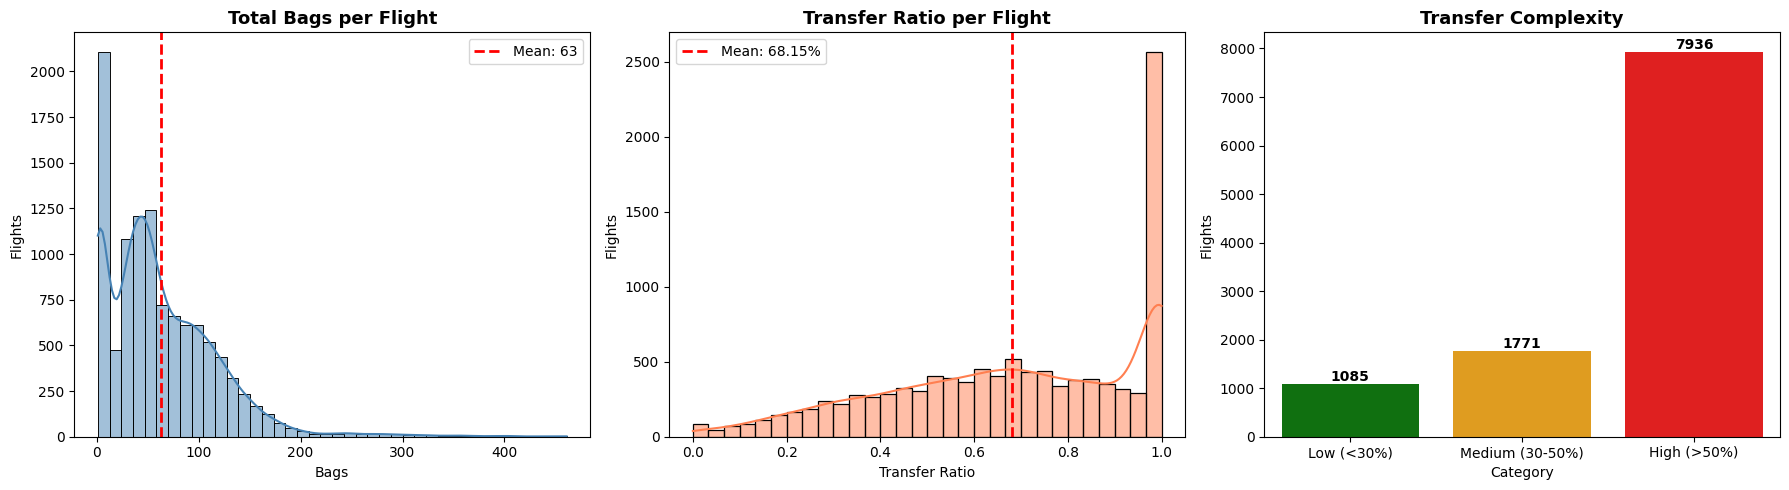

In [ ]:

axes[0].axvline(bag_summary['total_bags'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {bag_summary["total_bags"].mean():.0f}')
axes[0].set_title('Total Bags per Flight', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Bags')
axes[0].set_ylabel('Flights')
axes[0].legend()

# 2. Transfer Ratio Distribution
sns.histplot(bag_summary['transfer_ratio'], bins=30, kde=True, color='coral', ax=axes[1])
axes[1].axvline(bag_summary['transfer_ratio'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {bag_summary["transfer_ratio"].mean():.2%}')
axes[1].set_title('Transfer Ratio per Flight', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Transfer Ratio')
axes[1].set_ylabel('Flights')
axes[1].legend()

# 3. Transfer Complexity Categories
bag_summary['transfer_category'] = pd.cut(
    bag_summary['transfer_ratio'],
    bins=[0, 0.3, 0.5, 1.0],
    labels=['Low (<30%)', 'Medium (30-50%)', 'High (>50%)']
)
sns.countplot(
    data=bag_summary, 
    x='transfer_category', 
    hue='transfer_category', 
    palette={'Low (<30%)': 'green', 'Medium (30-50%)': 'orange', 'High (>50%)': 'red'},
    legend=False,
    ax=axes[2]
)
axes[2].set_title('Transfer Complexity', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Category')
axes[2].set_ylabel('Flights')

for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()


EDA Question 4: Passenger Load Analysis

In [112]:
unique_pnrs = pnr_flight_level.drop_duplicates(subset=['company_id', 'flight_number', 'scheduled_departure_date_local', 'record_locator'])
passenger_load = unique_pnrs.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local'])['total_pax'].sum().reset_index()
passenger_load = passenger_load.rename(columns={'total_pax': 'total_passengers'})

In [113]:
passenger_load.sample(5)

,company_id,flight_number,scheduled_departure_date_local,total_passengers
2940,OO,5984,2025-08-08,76
2735,OO,5841,2025-08-08,70
2332,OO,5593,2025-08-07,58
903,OO,4712,2025-08-08,76
3703,UA,660,2025-08-03,200


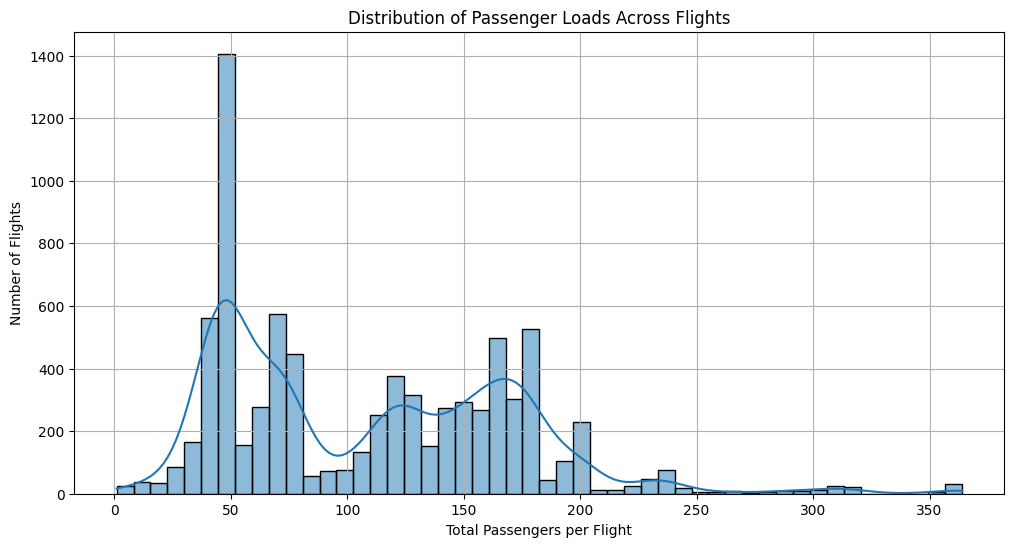

In [114]:
plt.figure(figsize=(12, 6))
sns.histplot(passenger_load['total_passengers'], bins=50, kde=True)
plt.title('Distribution of Passenger Loads Across Flights')
plt.xlabel('Total Passengers per Flight')
plt.ylabel('Number of Flights')
plt.grid(True)
plt.show()

In [116]:
passenger_load['scheduled_departure_date_local'] = pd.to_datetime(passenger_load['scheduled_departure_date_local'])
flight_level['scheduled_departure_date_local'] = pd.to_datetime(flight_level['scheduled_departure_date_local'])


Correlation between Load Factor and Departure Delay (for delayed flights): -0.25


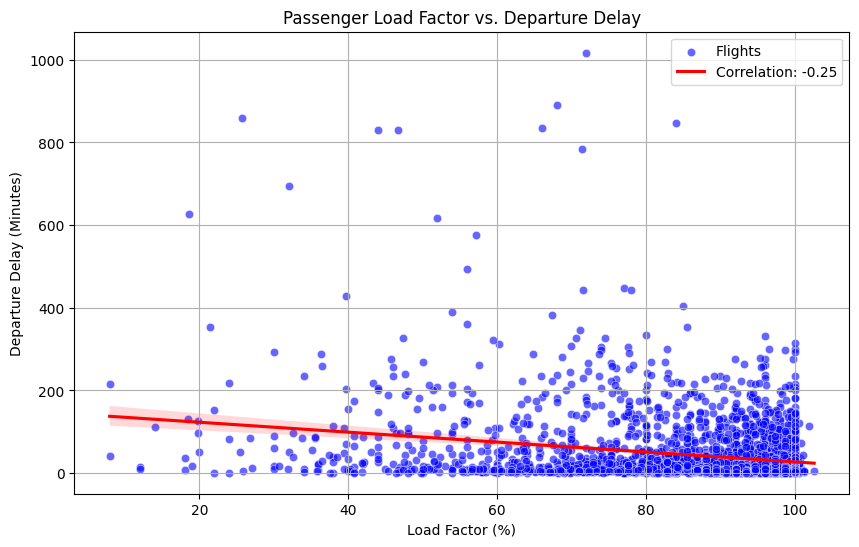

In [153]:
flight_data = pd.merge(passenger_load, flight_level, on=['company_id', 'flight_number', 'scheduled_departure_date_local'])

#  Load Factor (%)
flight_data['load_factor'] = (flight_data['total_passengers'] / flight_data['total_seats']) * 100

# Departure Delay in Minutes
flight_data['departure_delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

# finding correlation between Load Factor(higher loads) with Departure Delay(operational difficulty)
delayed_flights = flight_data[flight_data['departure_delay_minutes'] > 0]
correlation = delayed_flights['load_factor'].corr(delayed_flights['departure_delay_minutes'])
print(f"\nCorrelation between Load Factor and Departure Delay (for delayed flights): {correlation:.2f}")

# Visualize the relationship
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(
    x='load_factor',
    y='departure_delay_minutes',
    data=delayed_flights,
    color='blue',
    alpha=0.6,
    label='Flights'
)

# Regression line (add label here instead)
sns.regplot(
    x='load_factor',
    y='departure_delay_minutes',
    data=delayed_flights,
    scatter=False,
    color='red',
    label=f'Correlation: {correlation:.2f}'
)

plt.title('Passenger Load Factor vs. Departure Delay')
plt.xlabel('Load Factor (%)')
plt.ylabel('Departure Delay (Minutes)')
plt.legend()
plt.grid(True)
plt.show()

In [127]:
delayed_flights.sample(5)

,company_id,flight_number,scheduled_departure_date_local,total_passengers,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,carrier,scheduled_ground_time_minutes,actual_ground_time_minutes,minimum_turn_minutes,delay_minutes,status,ground_time_ratio,load_factor,departure_delay_minutes
1763,OO,5382,2025-08-01,42,ORD,FWA,2025-08-01 15:35:00+00:00,2025-08-01 17:47:00+00:00,2025-08-01 15:36:00+00:00,2025-08-01T17:40:00Z,50,Express,79,87,29,1.0,Delayed,2.724138,84.000000,1.0
5263,UA,1756,2025-08-15,154,ORD,YYZ,2025-08-15 21:14:00+00:00,2025-08-15 23:58:00+00:00,2025-08-15 21:33:00+00:00,2025-08-16T00:11:00Z,166,Mainline,54,80,65,19.0,Delayed,0.830769,92.771084,19.0
4841,UA,1525,2025-08-12,125,ORD,AUS,2025-08-12 13:40:00+00:00,2025-08-12 16:30:00+00:00,2025-08-12 13:45:00+00:00,2025-08-12T16:50:00Z,126,Mainline,60,79,43,5.0,Delayed,1.395349,99.206349,5.0
316,G7,4463,2025-08-09,32,ORD,ABE,2025-08-09 18:35:00+00:00,2025-08-09 21:55:00+00:00,2025-08-09 18:49:00+00:00,2025-08-09T21:52:00Z,50,Express,94,82,29,14.0,Delayed,3.241379,64.000000,14.0
7702,YX,3696,2025-08-01,55,ORD,CVG,2025-08-01 12:55:00+00:00,2025-08-01 15:21:00+00:00,2025-08-01 14:24:00+00:00,2025-08-01T16:39:00Z,70,Express,50,56,34,89.0,Delayed,1.470588,78.571429,89.0


EDA Question 5: Special Service Requests

🧹 Removed 126 extreme outlier flights (delay > 200 min)
📊 Analyzing 7,652 flights



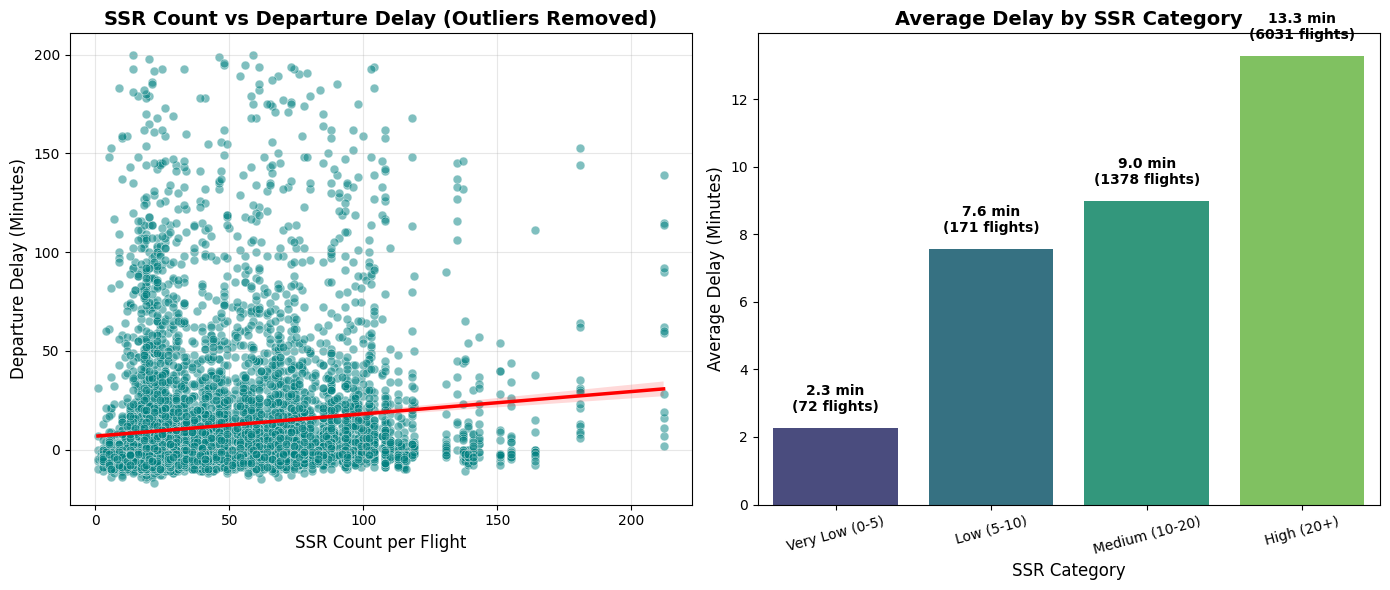

✓ Saved: ssr_delay_analysis.png

🎯 SSR COUNT vs DEPARTURE DELAY ANALYSIS (Outliers Removed)
Very Low (0-5)      :    2.3 min avg delay | 72 flights
Low (5-10)          :    7.6 min avg delay | 171 flights
Medium (10-20)      :    9.0 min avg delay | 1,378 flights
High (20+)          :   13.3 min avg delay | 6,031 flights

📈 Correlation coefficient (after removing outliers): 0.1152
   → Weak positive correlation: More SSRs associated with longer delays

📋 SSR Types:
  • Airport Wheelchair: 45,738
  • Manual Wheelchair: 3,641
  • Unaccompanied Minor: 1,706
  • Electric Wheelchair: 613


In [151]:
# --- Count SSR per flight ---
ssr_by_flight = (
    pnr_remark_level.groupby('flight_number')
    .size()
    .reset_index(name='ssr_count')
)

# Merge SSR with flight_level data
flight_with_ssr = flight_level.merge(ssr_by_flight, on='flight_number', how='left')
flight_with_ssr['ssr_count'] = flight_with_ssr['ssr_count'].fillna(0)

# --- REMOVE EXTREME OUTLIERS ---
# Remove delays > 200 minutes - likely operational disruptions unrelated to SSRs
original_count = len(flight_with_ssr)
flight_with_ssr = flight_with_ssr[flight_with_ssr['delay_minutes'] <= 200].copy()
removed_count = original_count - len(flight_with_ssr)
print(f"🧹 Removed {removed_count:,} extreme outlier flights (delay > 200 min)")
print(f"📊 Analyzing {len(flight_with_ssr):,} flights\n")

# Create SSR categories
flight_with_ssr['ssr_category'] = pd.cut(
    flight_with_ssr['ssr_count'],
    bins=[0, 5, 10, 20, float('inf')],
    labels=['Very Low (0-5)', 'Low (5-10)', 'Medium (10-20)', 'High (20+)']
)

# --- Visualization (2 plots) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1️⃣ SSR Count vs Delay - All Flights (cleaned)
sns.scatterplot(
    data=flight_with_ssr,
    x='ssr_count',
    y='delay_minutes',
    alpha=0.5,
    color='teal',
    s=40,
    ax=axes[0]
)
sns.regplot(
    data=flight_with_ssr,
    x='ssr_count',
    y='delay_minutes',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2.5},
    ax=axes[0],
)
axes[0].set_title('SSR Count vs Departure Delay (Outliers Removed)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('SSR Count per Flight', fontsize=12)
axes[0].set_ylabel('Departure Delay (Minutes)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# 2️⃣ Average Delay by SSR Category
avg_delay_by_category = flight_with_ssr.groupby('ssr_category', observed=True)['delay_minutes'].agg(['mean', 'count']).reset_index()
avg_delay_by_category.columns = ['SSR Category', 'Avg Delay', 'Flight Count']

sns.barplot(
    data=avg_delay_by_category,
    x='SSR Category',
    y='Avg Delay',
    hue='SSR Category',
    palette='viridis',
    legend=False,
    ax=axes[1]
)
axes[1].set_title('Average Delay by SSR Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('SSR Category', fontsize=12)
axes[1].set_ylabel('Average Delay (Minutes)', fontsize=12)
axes[1].tick_params(axis='x', rotation=15)

# Add labels on bars
for i, row in avg_delay_by_category.iterrows():
    axes[1].text(i, row['Avg Delay'] + 0.5, 
                f"{row['Avg Delay']:.1f} min\n({int(row['Flight Count'])} flights)", 
                ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('ssr_delay_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: ssr_delay_analysis.png")

# --- 📊 Statistical Summary ---
print("\n" + "="*70)
print("🎯 SSR COUNT vs DEPARTURE DELAY ANALYSIS (Outliers Removed)")
print("="*70)

for category in ['Very Low (0-5)', 'Low (5-10)', 'Medium (10-20)', 'High (20+)']:
    cat_data = flight_with_ssr[flight_with_ssr['ssr_category'] == category]
    avg_delay = cat_data['delay_minutes'].mean()
    count = len(cat_data)
    print(f"{category:20s}: {avg_delay:6.1f} min avg delay | {count:,} flights")

print("="*70)

# Overall correlation
correlation = flight_with_ssr[['ssr_count', 'delay_minutes']].corr().iloc[0, 1]
print(f"\n📈 Correlation coefficient (after removing outliers): {correlation:.4f}")

if correlation > 0.2:
    print("   → MODERATE positive correlation: More SSRs associated with longer delays")
elif correlation > 0.1:
    print("   → Weak positive correlation: More SSRs associated with longer delays")
elif correlation < -0.1:
    print("   → Negative correlation: More SSRs associated with shorter delays")
else:
    print("   → Very weak/no correlation between SSR count and delays")

print("\n📋 SSR Types:")
for ssr_type, count in ssr_types.items():
    print(f"  • {ssr_type}: {count:,}")